# Desafio 7 - Classiﬁcação de tweets utilizando o BERT

## Objetivo

Utilizar um modelo pré-treinado de PLN (BERT) para classiﬁcar o
sentimento de tweets em positivo ou negativo.

### Preparação dos Dados:

- Utilize um conjunto de dados de avaliações de tweets rotulados com sentimento (positivo/negativo).
- Divida o conjunto de dados em conjuntos de treinamento e teste.

### Pré-processamento dos Dados:

- Limpeza e tokenização dos textos dos tweets.
- Codiﬁcação dos tokens utilizando o vocabulário do modelo BERT.
- Adição de tokens especiais para separar frases e indicar o início e ﬁm do texto.

### Fine-tuning do Modelo BERT:

- Carregue o modelo pré-treinado BERT.
- Adicione camadas adicionais para a classiﬁcação de sentimento.
- Deﬁna a função de perda e o otimizador.
- Treine o modelo utilizando o conjunto de treinamento.

### Avaliação do Modelo:

- Avalie o modelo utilizando o conjunto de teste.
- Calcule a precisão, recall, e outras métricas de avaliação.

### Aplicação do Modelo:

- Teste o modelo com tweets não vistos antes para veriﬁcar sua eﬁcácia na classiﬁcação de sentimentos.

## Importando os pacotes necessarios

In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

2024-03-19 13:26:48.582604: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 13:26:48.605515: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 13:26:48.718909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 13:26:48.718966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 13:26:48.738908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Carregando o dataset e salvando em uma variável

In [2]:
path = "./datasets/raw/Twitter_Data.csv"
df_twitter_raw = pd.read_csv(path, sep = ",")

## Informações sobre os dados contidos no dataset

### Valores aleatórios

In [3]:
df_twitter_raw.sample(5)

,clean_text,category
92159,those who are trying let down narendra modi th...,1.0
79686,congratulations team missionshakti the success...,1.0
135413,why notits national electiontrs not national p...,0.0
153519,1after 1947 have elected our governments not s...,-1.0
10175,good love india modi king,1.0


### Informaçõees detalhadas

In [4]:
df_twitter_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


### Quantidade total de linhas do dataset

In [6]:
print(f"A quantidade total de linhas é: {df_twitter_raw.shape[0]}")

A quantidade total de linhas é: 162980


### EDA e Tratamento dos dados

### Tratamento dos dados

#### Copiando o dataset em nova variável para realizar os tratamentos de forma segura

In [7]:
df_twitter_processed = df_twitter_raw.copy(deep = True)
df_twitter_processed.sample(5)

,clean_text,category
13902,doesnt even have empirical cold calculated jus...,-1.0
103252,uttarakhand rally modi’ ‘mamabhanja’ jibe cong...,0.0
73460,has anyone ever seen modi smiling except when ...,1.0
45030,finally india now fourth spacepower ✊✊\nkudos ...,0.0
97928,the word ‘chowkidar’ watchman english carries ...,1.0


#### Renomeando as colunas

##### Verificando quais são as colunas contidas no dataset

In [8]:
df_twitter_processed.columns

Index(['clean_text', 'category'], dtype='object')

##### Realizando a renomeação

In [9]:
novas_colunas_nome = ["texto", "emocao"]
df_twitter_processed.columns = novas_colunas_nome
df_twitter_processed.sample(5)

,texto,emocao
81620,modi launches election campaign from meerut pr...,0.0
104610,well that’ not enough for now and for the last...,1.0
95879,can understand your frustration modi space cho...,0.0
48150,congratulations india\ncongratulations drdo\nc...,0.0
122419,congress first family wont back power modi ⚡,1.0


#### Alterando os valores da coluna "*emocao*"

##### Verificando os valores atuais

In [10]:
df_twitter_processed["emocao"].unique()

array([-1.,  0.,  1., nan])

Valores não-númericos/nulos foram achados, vamos tratar isso abaixo

##### Verificando os valores não-númericos/nulos na coluna "*emocao*"

In [14]:
df_twitter_processed["emocao"].isna().sum()

7

##### Verificando os valores não-númericos/nulos por todo o dataset

In [15]:
df_twitter_processed.isna().sum()

texto     4
emocao    7
dtype: int64

Como há somente 4 linhas faltantes da coluna "*texto*", será optado por excluir completamente as linhas

A quantidade de linhas excluidas não irá afetar muito a quantidades de dados do dataset

##### Excluindo as linhas onde há valores não-numéricos/nulos na coluna "*texto*"

In [16]:
df_twitter_processed = df_twitter_processed[~df_twitter_processed["texto"].isna()]

##### Nova contagem de valores não-numéricos/nulos

In [17]:
df_twitter_processed.isna().sum()

texto     0
emocao    7
dtype: int64

As linhas onde a coluna "*emocao*" possui valores nãp-numéricos/nulos não coincidio com a coluna "*texto*".

No entanto ainda será optado por excluir as linhas em questão, já que sua quantidade é muito pequena em comparação com o total do dataset

##### Excluindo as linhas onde há valores não-numéricos/nulos na coluna "*emocao*"

In [18]:
df_twitter_processed = df_twitter_processed[~df_twitter_processed["emocao"].isna()]

##### Nova contagem de valores não-numéricos/nulos

In [19]:
df_twitter_processed.isna().sum()

texto     0
emocao    0
dtype: int64

Agora vamos alterar os valores da coluna "*emocao*"

##### Realizando a alteração dos valores

In [20]:
dict_emocao_novos_valores = {
    -1 : 0, # NEGATIVO
    0 : 1,  # NEUTRO
    1 : 2   # POSITIVO
}

df_twitter_processed["emocao"] = df_twitter_processed["emocao"].map(dict_emocao_novos_valores)
df_twitter_processed["emocao"].unique()

array([0, 1, 2])

#### Alterando os tipos de dados contidos no dataset

Coluna *emocao*:
- Atual -> float64
- Novo -> uint8

Coluna *texto*:
- Atual -> Object
- Novo -> String

In [21]:
df_twitter_processed["emocao"] = df_twitter_processed["emocao"].astype("uint8")
df_twitter_processed["texto"] = df_twitter_processed["texto"].astype("string")

##### Verificando novos tipos

In [22]:
df_twitter_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   texto   162969 non-null  string
 1   emocao  162969 non-null  uint8 
dtypes: string(1), uint8(1)
memory usage: 2.6 MB


#### Salvando dataset atual em formato .pkl

In [24]:
path = "./datasets/processed/twitter_data.pkl"
df_twitter_processed.to_pickle(path)

### EDA

#### Quantidades unitárias de cada valor único da coluna "*emocao*"

In [26]:
df_twitter_processed["emocao"].value_counts()

emocao
2    72249
1    55211
0    35509
Name: count, dtype: int64

Podemos notar que:
- A maioria dos tweets é positivo, com o valor: 72249
- A quantidade de tweets neutros é de: 55211
- Os tweets negativos são a minoria, com o valor de: 35509

#### De forma gráfica

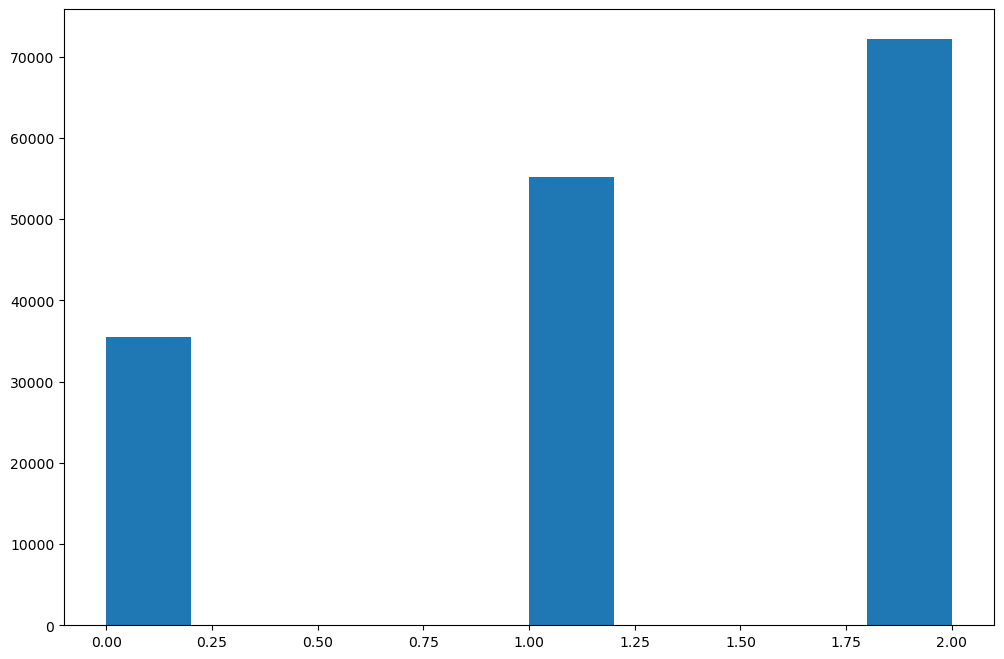

In [27]:
imagem = plt.figure(figsize=(12, 8))
plt.hist(x=df_twitter_processed["emocao"])
plt.show()

#### Desvio Padrão e Média Aritmética

In [29]:
print("O desvio padrão é de: ", df_twitter_processed["emocao"].std(),
    "\nA média aritmética é de: ", df_twitter_processed["emocao"].mean())

O desvio padrão é de:  0.7812794546501138 
A média aritmética é de:  1.225441648411661


#### Quantidade total de valores

In [35]:
print(f"{df_twitter_processed['emocao'].shape[0]} linhas")

162969 linhas
